# POS_CASH_balance Exploratory Data Analysis

## Introduction

Many people struggle to get loans because they don't have enough credit history, which can make them vulnerable to unfair lending practices. Home Credit Group addresses this issue by using alternative information, such as phone records and transaction data, to predict a person's ability to repay a loan. Improving these predictions helps reduce loan defaults, increases financial inclusion, and ensures more people receive fair, manageable loans.

In this analysis, the key outcome we want to predict is called the TARGET variable, found in the dataset file "application_train.csv." The TARGET variable indicates whether a loan was repaid (0) or defaulted on (1). Improving predictions on this variable allows Home Credit to better determine who will likely repay their loans, creating positive loan experiences and supporting long-term financial success.

## Goal

The POS_CASH_balance.csv dataset provides monthly balance snapshots of previous Point of Sale (POS) and cash loans that applicants had with Home Credit. Each row in this dataset represents a specific month's balance for a given loan, capturing information on both consumer credit and cash loans that the applicant has previously taken out with Home Credit. The dataset is detailed, containing multiple rows for each applicant based on the number of loans they have and the available monthly data for those loans.

The goal when aggregating this dataset for the machine learning model is to extract key features that reflect the applicant's financial behavior and loan management. Aggregating features such as the total balance, average balance, or frequency of changes in the balance over time can help assess the applicant's usage of credit and their ability to manage outstanding loans. Additionally, tracking trends in the POS and cash loan balances, such as whether the applicant consistently carries a balance or pays off loans in full, can provide valuable insights into their financial habits and risk profile. By summarizing this data effectively, we can create features that offer predictive value for loan repayment behavior, ultimately supporting the goal of predicting whether an applicant will repay a new loan successfully.

# Notebook Properation

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import statsmodels.formula.api as smf

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_curve, auc, confusion_matrix, roc_auc_score

import lightgbm as lgb
from lightgbm import LGBMClassifier

In [2]:
from eda_utilities import *

In [3]:
train = pd.read_csv('data/application_train.csv', encoding = 'ISO-8859-1')
pos = pd.read_csv('data/POS_CASH_balance.csv', encoding = 'ISO-8859-1')

### Check the number of rows, columns

In [4]:
pos.shape

(10001358, 8)

The POS dataset contains 10,001,358 rows and 8 columns, indicating that processing and analyzing the datset will likely require substantial computational resources.

### Any duplicates?

In [5]:
print(f"Number of duplicate rows: {len(pos[pos.duplicated(keep=False)])}")

Number of duplicate rows: 0


In [6]:
print(f"Number of duplicate rows (excluding SK_ID_CURR): {len(pos.drop(columns=['SK_ID_CURR'])[pos.drop(columns=['SK_ID_CURR']).duplicated(keep=False)])}")

Number of duplicate rows (excluding SK_ID_CURR): 0


In [7]:
print(f"Number of duplicate rows (excluding SK_ID_PREV): {len(pos.drop(columns=['SK_ID_PREV'])[pos.drop(columns=['SK_ID_PREV']).duplicated(keep=False)])}")

Number of duplicate rows (excluding SK_ID_PREV): 57605


The POS dataset shows 57605 duplicate entries when excluding the unique identifier SK_ID_PREV indeed suggest that the same client (SK_ID_CURR) has multiple records in the dataset because they have applied for credit multiple times.

## Frame the Problem and look at the big picture

The data is highly imbalanced, with 91.9% in class 0 (no payment issues) and only 8.1% in class 1 (payment issues). This can cause models to favor the majority class, so techniques like resampling or class weighting are needed to handle it effectively.

### Check on the column datatype, null counts, distinct values, to get a better understanding of the data

In [8]:
column_summary(pos)

,col_name,col_dtype,num_of_nulls,num_of_non_nulls,num_of_distinct_values,distinct_values_counts
0,SK_ID_PREV,int64,0,10001358,936325,"{1856103: 96, 2706683: 96, 1617536: 96, 136460..."
1,SK_ID_CURR,int64,0,10001358,337252,"{265042: 295, 172612: 247, 309133: 246, 127659..."
2,MONTHS_BALANCE,int64,0,10001358,96,"{-10: 216441, -11: 216023, -9: 215558, -12: 21..."
3,CNT_INSTALMENT,float64,26071,9975287,73,"{12.0: 2496845, 24.0: 1517472, 10.0: 1243449, ..."
4,CNT_INSTALMENT_FUTURE,float64,26087,9975271,79,"{0.0: 1185960, 6.0: 614058, 4.0: 613632, 5.0: ..."
5,NAME_CONTRACT_STATUS,object,0,10001358,9,"{'Active': 9151119, 'Completed': 744883, 'Sign..."
6,SK_DPD,int64,0,10001358,3400,"{0: 9706131, 1: 21872, 2: 17358, 3: 14403, 4: ..."
7,SK_DPD_DEF,int64,0,10001358,2307,"{0: 9887389, 1: 22134, 2: 14690, 3: 11652, 4: ..."


In [9]:
pos_summary = column_summary(pos)
pos_summary.to_csv('data_summaries/pos_summary.csv')

Saving the summary as a CSV file allows for a clearer and more structured view of the data, making it easier to analyze column details, missing values, and distinct values outside of the code environment.

### Check the distribution of what data type is being used in the dataset

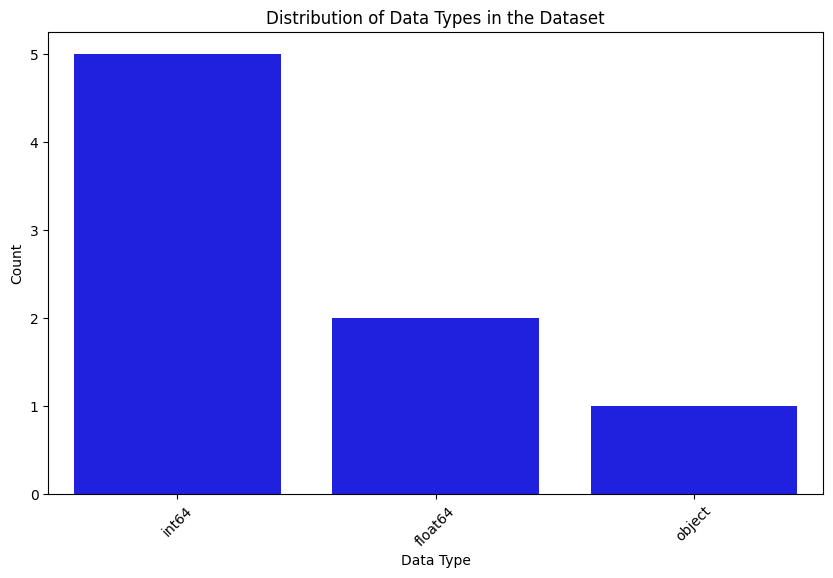

In [10]:
data_types = pos.dtypes.value_counts()

plt.figure(figsize=(10, 6))
sns.barplot(x=data_types.index, y=data_types.values, color='blue')
plt.title('Distribution of Data Types in the Dataset')
plt.xlabel('Data Type')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

int64 is the most common type, with more than 5 features. float64 and object types have fewer occurrences, with float64 being slightly more prevalent than object.

These differences suggest the datasets differ significantly in complexity and the variety of feature types available. The first dataset is richer in numerical features (especially floats), while the second is evenly split among numerical (integers and floats) and categorical (object) types.

# Aggregating and Creating Features

The POS_CASH_balance dataset contains detailed monthly records of previous point-of-sale (POS) and cash loans for each customer. Due to its large size (~10 million rows), it was processed independently from other datasets to reduce memory usage and processing time.

Since this dataset includes many monthly records per loan, we aggregated the data to create customer-level features that summarize past loan behavior efficiently. These features help the machine learning model understand how applicants managed previous loans, which can indicate their ability to repay future loans.

In [11]:
# Convert NAME_CONTRACT_STATUS to dummies
status_dummies = pd.get_dummies(pos['NAME_CONTRACT_STATUS'], prefix='STATUS')
pos = pd.concat([pos, status_dummies], axis=1)

# Identify status columns
status_cols = [col for col in pos.columns if col.startswith('STATUS_')]

# Define aggregation dictionary
agg_dict_prev = {
    'SK_ID_CURR': 'first',
    'MONTHS_BALANCE': ['count', 'max'],
    'CNT_INSTALMENT': ['mean'],
    'CNT_INSTALMENT_FUTURE': ['min', 'mean'],
    'SK_DPD': ['max', 'mean', 'sum'],
    'SK_DPD_DEF': ['max', 'mean', 'sum'],
}
for col in status_cols:
    agg_dict_prev[col] = ['sum', 'mean']

# Perform aggregation
pos_prev_agg = pos.groupby('SK_ID_PREV').agg(agg_dict_prev)

# Flatten column names
pos_prev_agg.columns = [f"{col[0]}_{col[1].upper()}" if col[1] != '' else col[0]
                        for col in pos_prev_agg.columns]
pos_prev_agg.reset_index(inplace=True)
pos_prev_agg.rename(columns={'SK_ID_CURR_FIRST': 'SK_ID_CURR'}, inplace=True)

# Identify status sum and mean columns
status_sum_cols = [col for col in pos_prev_agg.columns
                   if col.endswith('_SUM') and col.startswith('STATUS_')]
status_mean_cols = [col for col in pos_prev_agg.columns
                    if col.endswith('_MEAN') and col.startswith('STATUS_')]

# Define aggregation dictionary
agg_dict_curr = {
    'SK_ID_PREV': ['count'],
    'MONTHS_BALANCE_COUNT': ['sum', 'mean', 'max'],
    'MONTHS_BALANCE_MAX': ['max'],
    'CNT_INSTALMENT_MEAN': ['mean', 'max', 'min'],
    'CNT_INSTALMENT_FUTURE_MIN': ['min', 'mean'],
    'CNT_INSTALMENT_FUTURE_MEAN': ['mean'],
    'SK_DPD_MAX': ['max', 'mean'],
    'SK_DPD_MEAN': ['mean'],
    'SK_DPD_SUM': ['sum'],
    'SK_DPD_DEF_MAX': ['max', 'mean'],
    'SK_DPD_DEF_MEAN': ['mean'],
    'SK_DPD_DEF_SUM': ['sum'],
}
for col in status_sum_cols:
    agg_dict_curr[col] = ['sum']
for col in status_mean_cols:
    agg_dict_curr[col] = ['mean']

# Perform aggregation
pos_final_agg = pos_prev_agg.groupby('SK_ID_CURR').agg(agg_dict_curr)

# Flatten and prefix column names
pos_final_agg.columns = ["POS_" + "_".join(col).upper() for col in pos_final_agg.columns]
pos_final_agg.reset_index(inplace=True)

# Merge with train to include TARGET
agg_pos = pos_final_agg.merge(train[['SK_ID_CURR', 'TARGET']],on='SK_ID_CURR', how='left')

agg_pos.head()

,SK_ID_CURR,POS_SK_ID_PREV_COUNT,POS_MONTHS_BALANCE_COUNT_SUM,POS_MONTHS_BALANCE_COUNT_MEAN,POS_MONTHS_BALANCE_COUNT_MAX,POS_MONTHS_BALANCE_MAX_MAX,POS_CNT_INSTALMENT_MEAN_MEAN,POS_CNT_INSTALMENT_MEAN_MAX,POS_CNT_INSTALMENT_MEAN_MIN,POS_CNT_INSTALMENT_FUTURE_MIN_MIN,...,POS_STATUS_ACTIVE_MEAN_MEAN,POS_STATUS_AMORTIZED DEBT_MEAN_MEAN,POS_STATUS_APPROVED_MEAN_MEAN,POS_STATUS_CANCELED_MEAN_MEAN,POS_STATUS_COMPLETED_MEAN_MEAN,POS_STATUS_DEMAND_MEAN_MEAN,POS_STATUS_RETURNED TO THE STORE_MEAN_MEAN,POS_STATUS_SIGNED_MEAN_MEAN,POS_STATUS_XNA_MEAN_MEAN,TARGET
0,100001,2,9,4.500000,5,-53,4.000000,4.00,4.00,0.0,...,0.775000,0.0,0.0,0.0,0.225000,0.0,0.0,0.000000,0.0,NaN
1,100002,1,19,19.000000,19,-1,24.000000,24.00,24.00,6.0,...,1.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,1.0
2,100003,3,28,9.333333,12,-18,9.791667,12.00,6.00,0.0,...,0.916667,0.0,0.0,0.0,0.083333,0.0,0.0,0.000000,0.0,0.0
3,100004,1,4,4.000000,4,-24,3.750000,3.75,3.75,0.0,...,0.750000,0.0,0.0,0.0,0.250000,0.0,0.0,0.000000,0.0,0.0
4,100005,1,11,11.000000,11,-15,11.700000,11.70,11.70,0.0,...,0.818182,0.0,0.0,0.0,0.090909,0.0,0.0,0.090909,0.0,NaN


In [12]:
agg_pos.shape

(337252, 39)

After aggregation, the agg_pos dataset contains 337,252 rows and 39 features, summarizing previous loan applications at the client level.

# EDA

Since all our features are numerical after aggregation, we focused on showing how each one is distributed and how it relates to the TARGET variable.

* If a feature has fewer than 20 unique values, we used bar plots and proportion plots to make the patterns easy to see.
* If a feature has more than 20 unique values, we used histograms and boxplots to show the distribution and spot any outliers.

In [13]:
agg_pos_eda = agg_pos[agg_pos['TARGET'].notnull()]

### Client and Contract Identifiers

In [14]:
agg_pos_eda['SK_ID_CURR'].nunique()

289444

There are 289,444 unique clients in the dataset, each identified by SK_ID_CURR, representing individual client records for further analysis.

### Time-Related Features

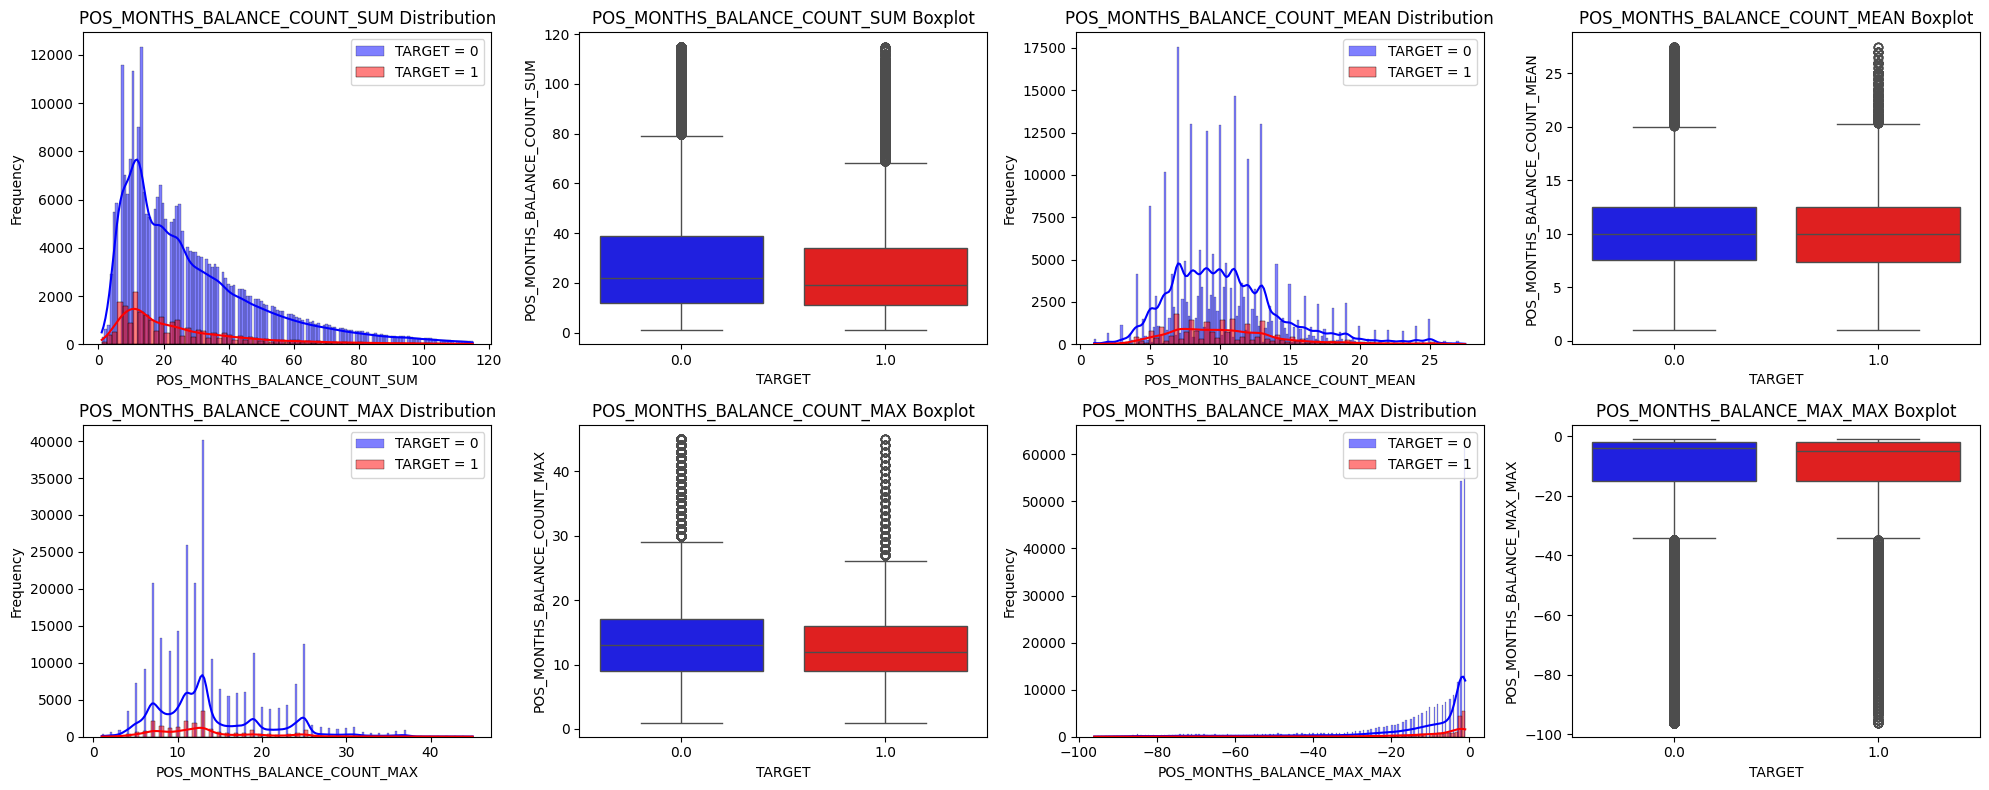

In [15]:
plot_multiple_numeric_dists(
    agg_pos_eda,
    features = [
         'POS_MONTHS_BALANCE_COUNT_SUM',
         'POS_MONTHS_BALANCE_COUNT_MEAN',
         'POS_MONTHS_BALANCE_COUNT_MAX',
         'POS_MONTHS_BALANCE_MAX_MAX'
    ],
    target = 'TARGET',
    remove_outliers = True,
    outlier_features = [
         'POS_MONTHS_BALANCE_COUNT_SUM',
         'POS_MONTHS_BALANCE_COUNT_MEAN',
         'POS_MONTHS_BALANCE_COUNT_MAX',
         'POS_MONTHS_BALANCE_MAX_MAX'
    ],
    percentile =0.99
)

1. POS_MONTHS_BALANCE_COUNT_SUM: The distribution is heavily skewed with most values concentrated near 0. The boxplot shows that TARGET=1 (defaults) has a slightly wider spread compared to TARGET=0 (non-defaults), suggesting that clients with higher values in POS_MONTHS_BALANCE_COUNT_SUM may be more likely to default. This feature could help to identify defaults, but outliers should be handled properly.
2. POS_MONTHS_BALANCE_COUNT_MAX: This feature has a similar distribution to POS_MONTHS_BALANCE_COUNT_SUM, with most values clustered near 0 and a few extreme values. The boxplot indicates that there are noticeable outliers, particularly for TARGET=1, suggesting that clients with more months of balance history may be at higher risk of default. This feature could be informative after handling the outliers and skewness.
3. POS_MONTHS_BALANCE_COUNT_MEAN: The distribution is right-skewed, with most values concentrated at the lower end and a long tail. The boxplot shows that TARGET=1 has a wider spread compared to TARGET=0. This indicates that clients with a higher number of months in their average balance history are somewhat more likely to default, but careful preprocessing (e.g., transformation) is needed to address the skewness.
4. POS_MONTHS_BALANCE_MAX_MAX: The distribution for this feature shows extreme values, with a concentration of values near 0 and very large negative values. The boxplot further highlights the significant spread, particularly for TARGET=1, suggesting that clients with larger negative balances may have a higher likelihood of defaulting. This feature might be useful for distinguishing defaults, but outlier handling will be crucial due to the extreme values.

### Installment Features

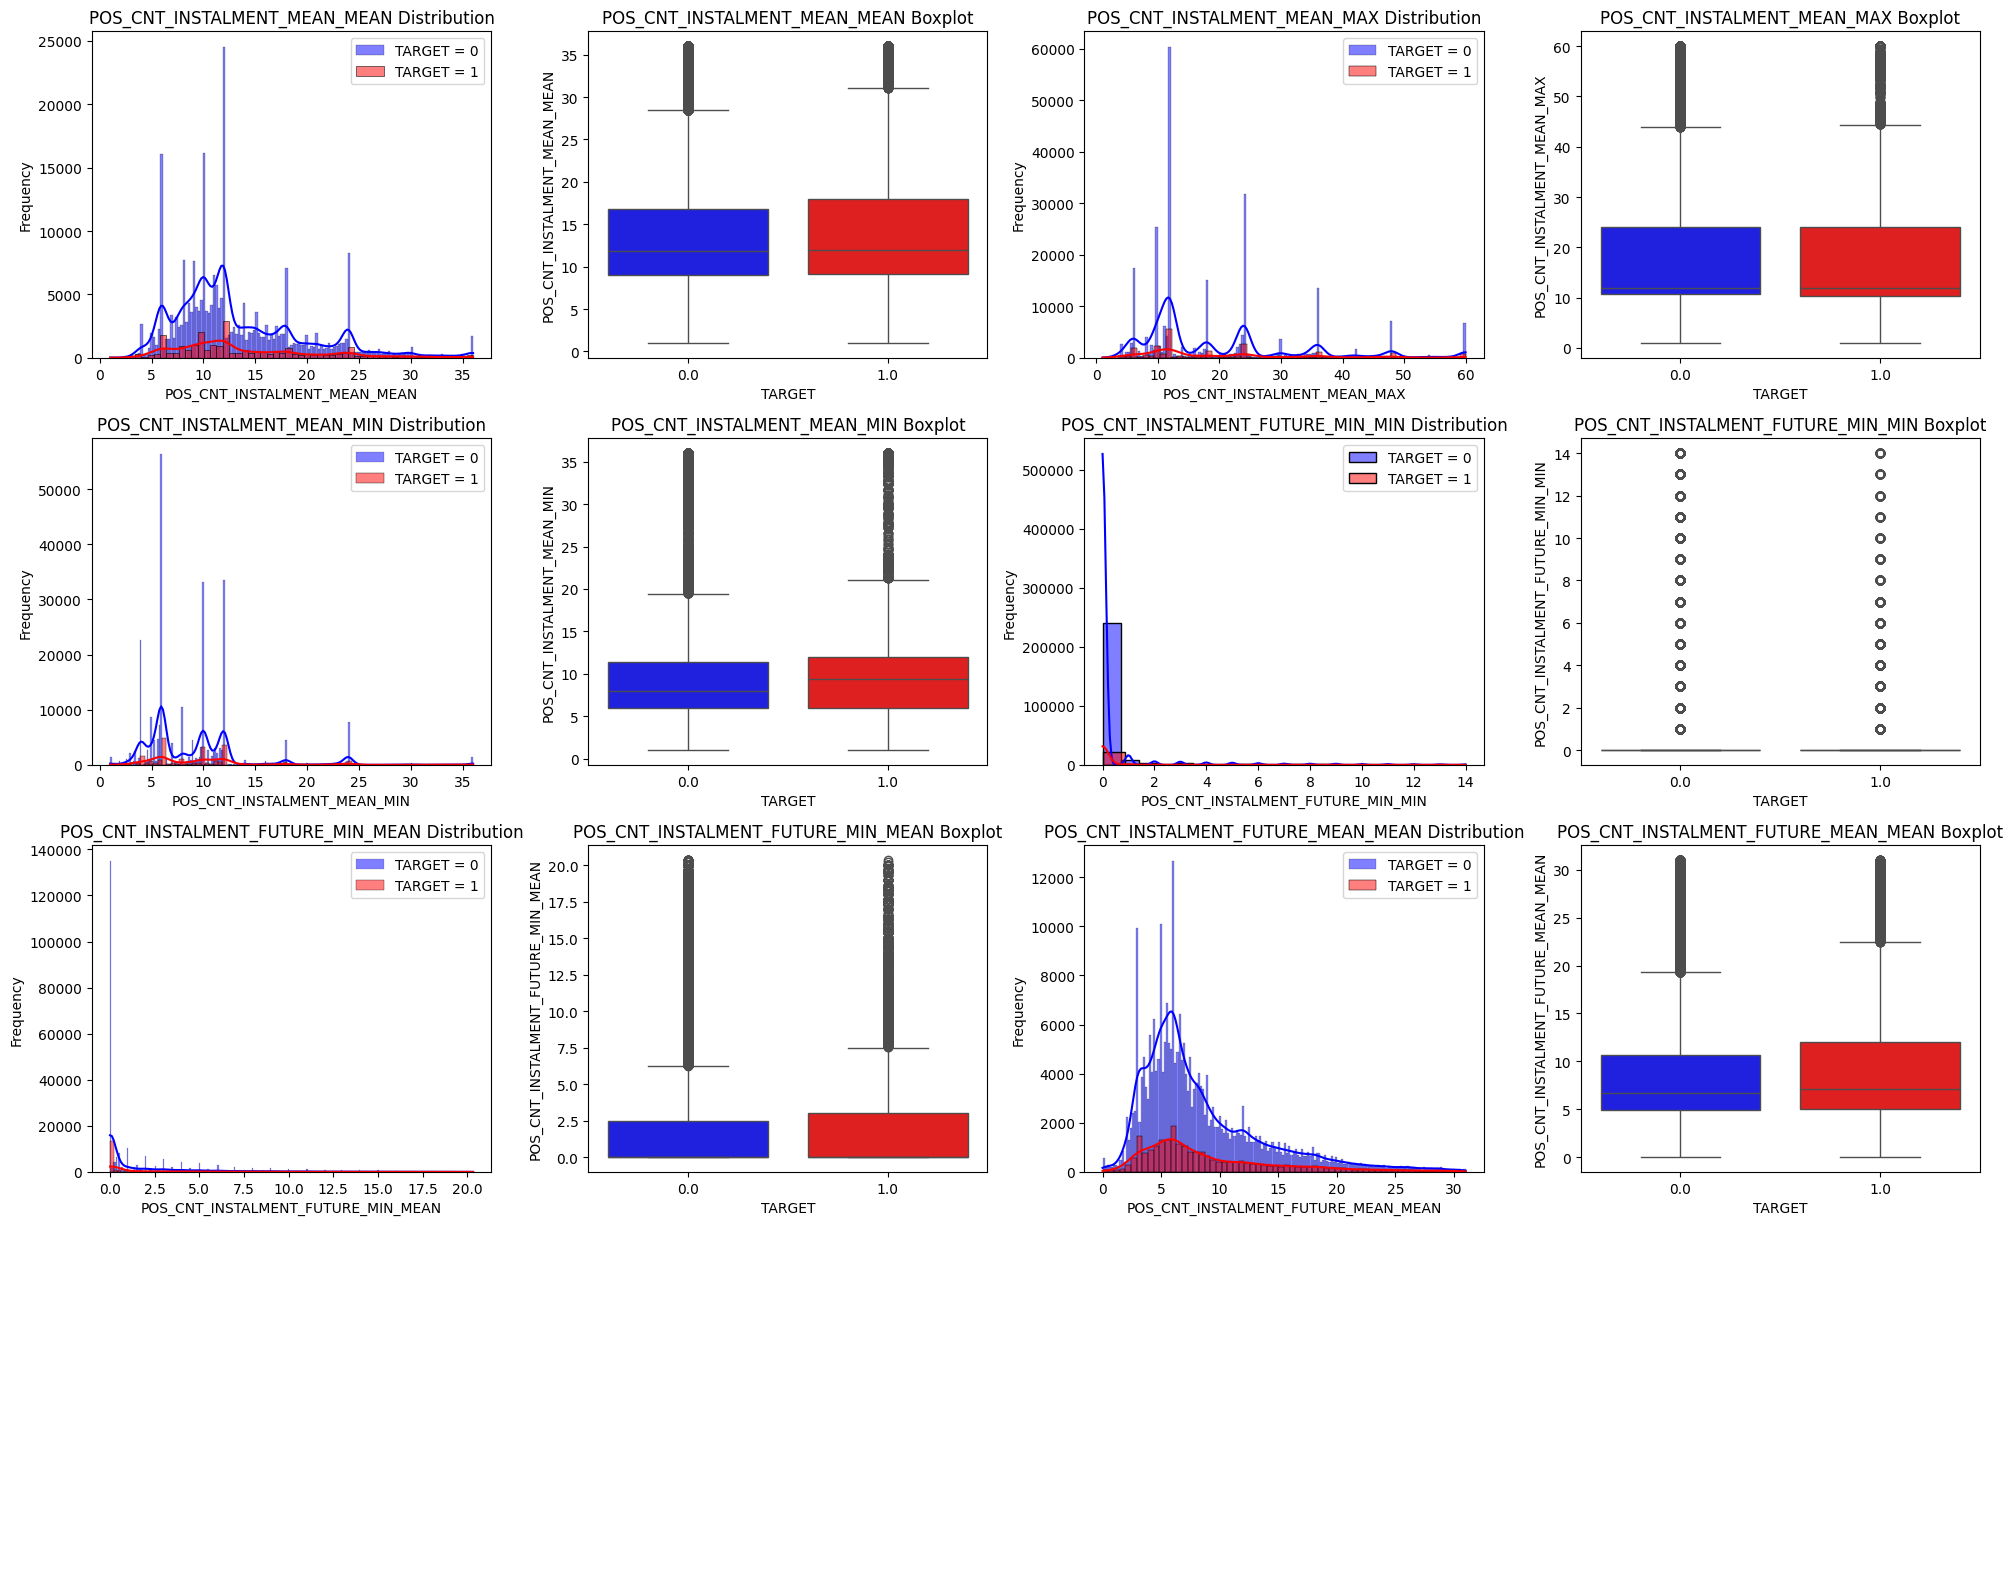

In [16]:
plot_multiple_numeric_dists(
    agg_pos_eda,
    features = [
        'POS_CNT_INSTALMENT_MEAN_MEAN',
        'POS_CNT_INSTALMENT_MEAN_MAX',
        'POS_CNT_INSTALMENT_MEAN_MIN',
        'POS_CNT_INSTALMENT_FUTURE_MIN_MIN',
        'POS_CNT_INSTALMENT_FUTURE_MIN_MEAN',
        'POS_CNT_INSTALMENT_FUTURE_MEAN_MEAN'
    ],
    target = 'TARGET',
    remove_outliers = True,
    outlier_features = [
        'POS_CNT_INSTALMENT_MEAN_MEAN',
        'POS_CNT_INSTALMENT_MEAN_MAX',
        'POS_CNT_INSTALMENT_MEAN_MIN',
        'POS_CNT_INSTALMENT_FUTURE_MIN_MIN',
        'POS_CNT_INSTALMENT_FUTURE_MIN_MEAN',
        'POS_CNT_INSTALMENT_FUTURE_MEAN_MEAN'
    ],
    percentile =0.99
)

1. POS_CNT_INSTALMENT_MEAN_MEAN: The distribution is highly skewed with a concentration around lower values and a few extreme peaks. The boxplot indicates that the spread for TARGET=1 (defaults) is wider than TARGET=0 (non-defaults), suggesting that clients with higher POS_CNT_INSTALMENT_MEAN_MEAN values are more likely to default. This feature could be useful for distinguishing between default and non-default clients, but outliers need to be managed.
2. POS_CNT_INSTALMENT_MEAN_MIN: The distribution shows a concentration of values near 0, and the boxplot shows outliers, particularly for TARGET=1. While the overall distribution is skewed toward lower values, the wider spread for TARGET=1 suggests that clients with higher values in POS_CNT_INSTALMENT_MEAN_MIN may have a higher risk of default. However, the feature requires handling of skewness and outliers.
3. POS_CNT_INSTALMENT_MEAN_MAX: The distribution is similar to POS_CNT_INSTALMENT_MEAN_MEAN, with a concentration around lower values and extreme peaks. The boxplot indicates that POS_CNT_INSTALMENT_MEAN_MAX for TARGET=1 has a wider spread, suggesting that clients with larger values might be more likely to default. This feature shows promise, but outlier treatment is essential.
4. POS_CNT_INSTALMENT_FUTURE_MIN_MIN: This feature has a distribution concentrated around 0, with a long tail. The boxplot reveals a significant difference between TARGET=0 and TARGET=1, with TARGET=1 showing more extreme values. This indicates that POS_CNT_INSTALMENT_FUTURE_MIN_MIN might be useful for identifying clients at higher risk of default, but the feature would benefit from outlier management.
5. POS_CNT_INSTALMENT_FUTURE_MEAN_MEAN: The distribution is right-skewed, with most values concentrated at lower values. The boxplot shows a wider spread for TARGET=1, suggesting that clients with larger POS_CNT_INSTALMENT_FUTURE_MEAN_MEAN values are more likely to default. However, outliers should be handled appropriately for it to be used effectively in the model.
6. POS_CNT_INSTALMENT_FUTURE_MEAN_MAX: The distribution shows a similar pattern to POS_CNT_INSTALMENT_FUTURE_MEAN_MEAN, with a concentration of values near 0 and a long tail. The boxplot shows that TARGET=1 has a wider spread, indicating that clients with higher values in this feature are more likely to default. While this feature could be useful for the model, it requires addressing outliers and skewness for better performance.

### Days Past Due (DPD) Features

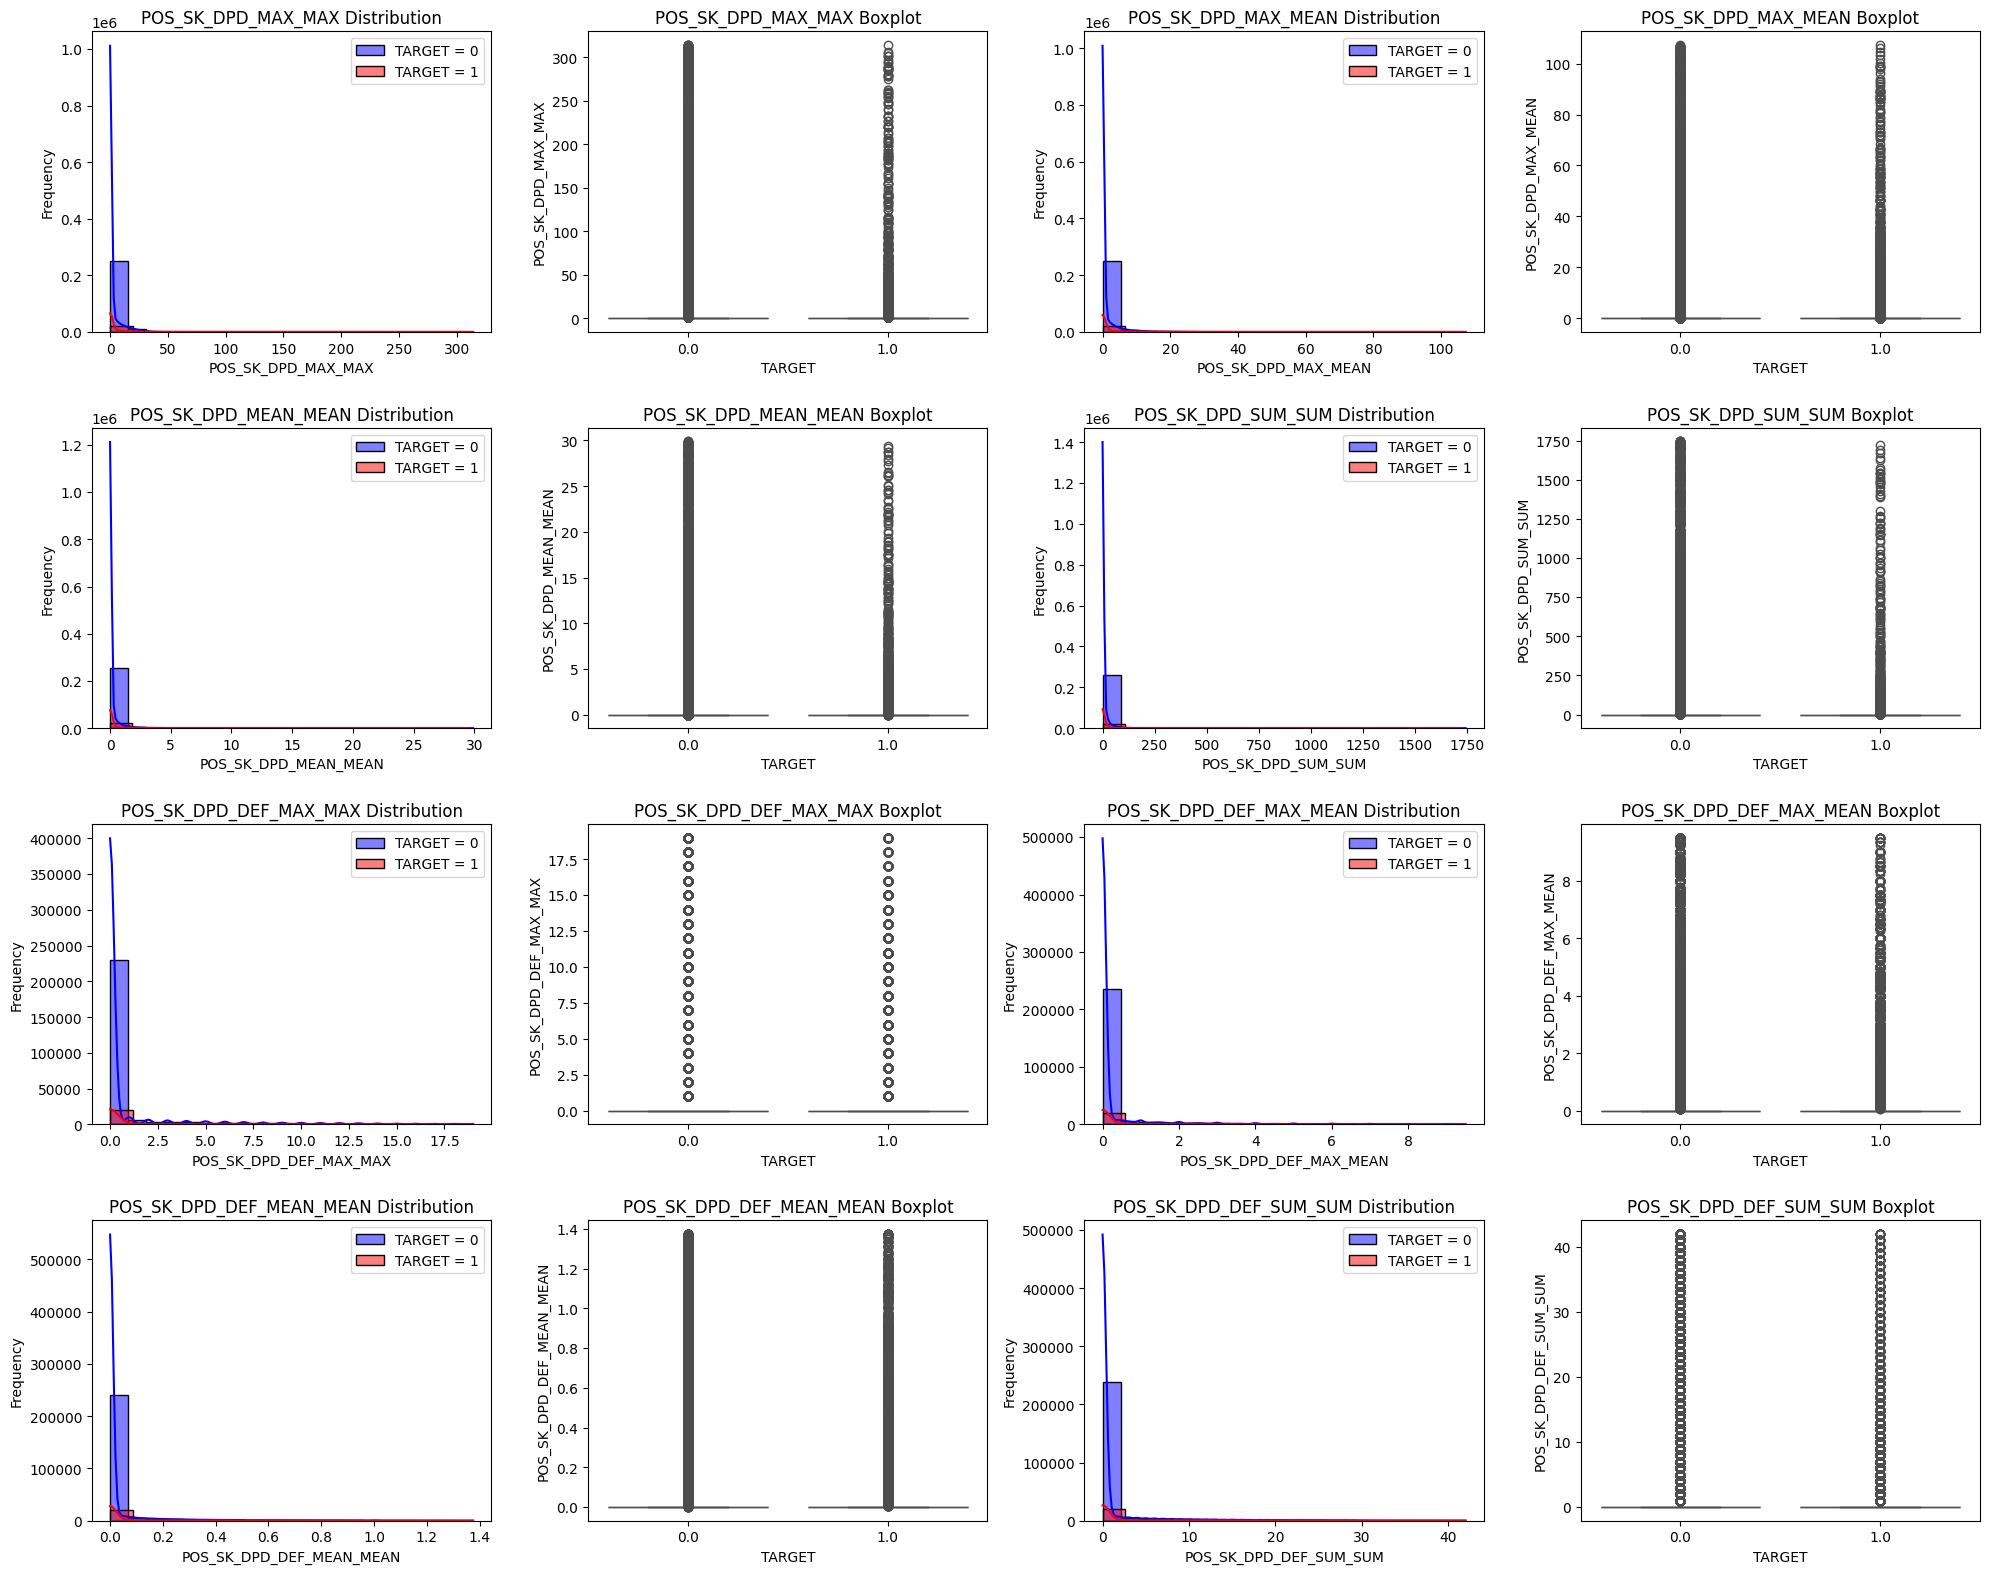

In [17]:
plot_multiple_numeric_dists(
    agg_pos_eda,
    features = [
        'POS_SK_DPD_MAX_MAX',
        'POS_SK_DPD_MAX_MEAN',
        'POS_SK_DPD_MEAN_MEAN',
        'POS_SK_DPD_SUM_SUM',
        'POS_SK_DPD_DEF_MAX_MAX',
        'POS_SK_DPD_DEF_MAX_MEAN',
        'POS_SK_DPD_DEF_MEAN_MEAN',
        'POS_SK_DPD_DEF_SUM_SUM'
    ],
    target = 'TARGET',
    remove_outliers = True,
    outlier_features = [
        'POS_SK_DPD_MAX_MAX',
        'POS_SK_DPD_MAX_MEAN',
        'POS_SK_DPD_MEAN_MEAN',
        'POS_SK_DPD_SUM_SUM',
        'POS_SK_DPD_DEF_MAX_MAX',
        'POS_SK_DPD_DEF_MAX_MEAN',
        'POS_SK_DPD_DEF_MEAN_MEAN',
        'POS_SK_DPD_DEF_SUM_SUM'
    ],
    percentile =0.99
)

1. POS_SK_DPD_MAX_MAX: The distribution is highly skewed with most values concentrated near 0, and the boxplot reveals a significant number of outliers for TARGET=1 (defaults). The concentration of values at 0 and the wide spread for TARGET=1 suggest that clients with higher POS_SK_DPD_MAX_MAX values are more likely to default, but proper handling of outliers is necessary.
2. POS_SK_DPD_MAX_MEAN: Similar to POS_SK_DPD_MAX_MAX, the distribution is heavily skewed, with values mostly near 0 and a few extreme values. The boxplot shows a wider spread for TARGET=1, indicating that clients with higher values in this feature may have a higher risk of defaulting. This feature shows potential but needs preprocessing to handle the outliers and skewness.
3. POS_SK_DPD_SUM_MAX: This feature has a similar distribution pattern, with a concentration of values around 0 and outliers for TARGET=1. The boxplot suggests that clients with higher values in POS_SK_DPD_SUM_MAX may be more likely to default, but the feature would need proper transformation or outlier removal to be effectively used in the model.
4. POS_SK_DPD_SUM_MEAN: The distribution is right-skewed, with values mainly near 0. The boxplot reveals that the spread for TARGET=1 is wider than TARGET=0, which suggests that clients with higher POS_SK_DPD_SUM_MEAN values may have a higher likelihood of defaulting. This feature could be valuable, but it requires transformation for the skewed data.
5. POS_SK_DPD_DEF_MAX_MAX: The distribution is concentrated near 0, with a few larger values. The boxplot indicates a wider spread for TARGET=1, suggesting that clients with higher values in POS_SK_DPD_DEF_MAX_MAX are more likely to default. However, outliers need to be addressed to improve its usability in the model.
6. POS_SK_DPD_DEF_MAX_MEAN: Similar to other MAX features, this distribution is right-skewed, with most values near 0. The boxplot shows that TARGET=1 has a wider spread, making this feature potentially useful for identifying defaults. Preprocessing for skewness and outliers is recommended.
7. POS_SK_DPD_DEF_SUM_MAX: The distribution shows a concentration of values around 0 with a few extreme outliers. The boxplot shows a noticeable difference between TARGET=0 and TARGET=1, with TARGET=1 having more spread. This suggests that clients with larger POS_SK_DPD_DEF_SUM_MAX values might be more likely to default, but outliers need to be handled.
8. POS_SK_DPD_DEF_SUM_MEAN: The distribution for this feature is heavily right-skewed, with most values near 0. The boxplot shows that the spread for TARGET=1 is wider compared to TARGET=0, indicating that clients with higher POS_SK_DPD_DEF_SUM_MEAN values might be at a higher risk of default. As with the other features, outliers should be addressed before using this feature in the model.

### Contract Status Features (Sum Aggregations)

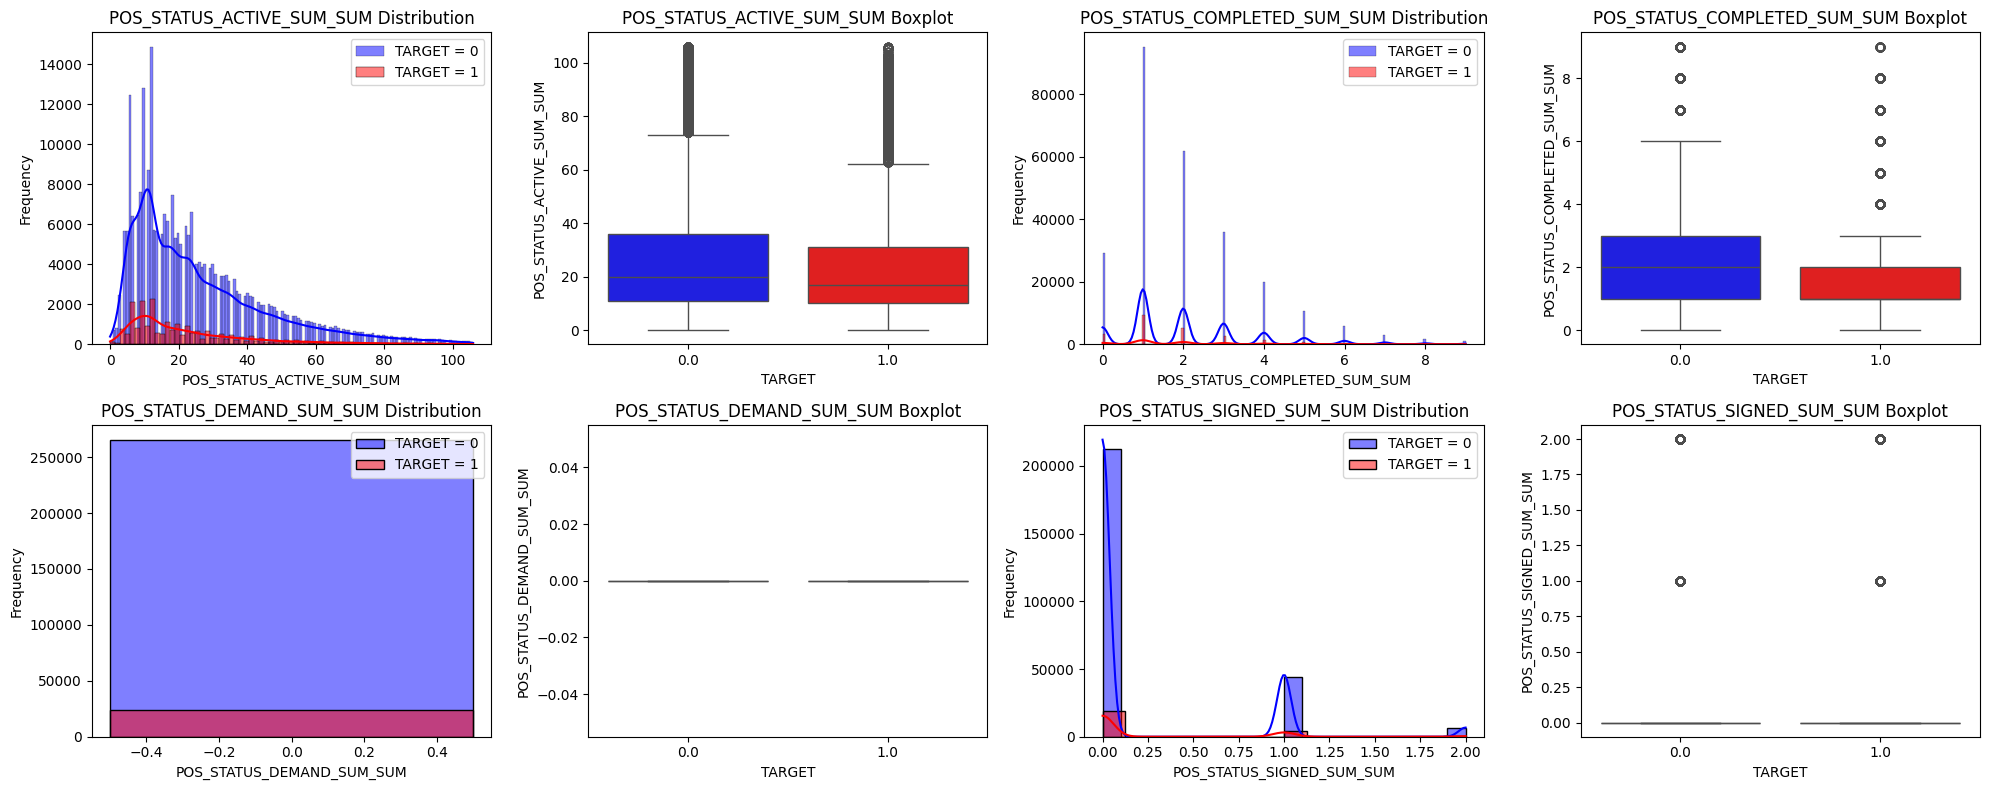

In [18]:
plot_multiple_numeric_dists(
    agg_pos_eda,
    features = [
        'POS_STATUS_ACTIVE_SUM_SUM',
        'POS_STATUS_COMPLETED_SUM_SUM',
        'POS_STATUS_DEMAND_SUM_SUM',
        'POS_STATUS_SIGNED_SUM_SUM'
    ],
    target = 'TARGET',
    remove_outliers = True,
    outlier_features = [
        'POS_STATUS_ACTIVE_SUM_SUM',
        'POS_STATUS_COMPLETED_SUM_SUM',
        'POS_STATUS_DEMAND_SUM_SUM',
        'POS_STATUS_SIGNED_SUM_SUM'
    ],
    percentile =0.99
)

1. POS_STATUS_ACTIVE_SUM_SUM: The distribution for this feature is right-skewed, with most values concentrated at lower levels and a long tail. The boxplot reveals that the spread for TARGET=1 (defaults) is slightly wider than for TARGET=0 (non-defaults), suggesting that clients with higher values in POS_STATUS_ACTIVE_SUM_SUM might have a higher probability of defaulting. However, outlier treatment is needed due to extreme values in the upper range.
2. POS_STATUS_DEMAND_SUM_SUM: as no variation across the dataset—its values are essentially constant and centered at 0 for both TARGET = 0 and TARGET = 1. The distribution and boxplot show no spread or difference between the two classes. Because it carries no meaningful information, this feature is not useful for modeling and should be removed.
3. POS_STATUS_COMPLETED_SUM_SUM: This feature shows a distribution with a peak near 0, and some extreme outliers. The boxplot reveals that TARGET=1 has a slightly lower median compared to TARGET=0, and there are several outliers for both target classes. This feature could provide some information about defaults, but the significant number of outliers requires handling before using it in a model.
4. POS_STATUS_SIGNED_SUM_SUM: The distribution is highly skewed, with most values concentrated near 0. The boxplot shows a notable difference between TARGET=0 and TARGET=1, with some extreme outliers for both groups. This feature might be useful for distinguishing defaults, but the extreme outliers need to be dealt with to prevent them from negatively affecting model performance.


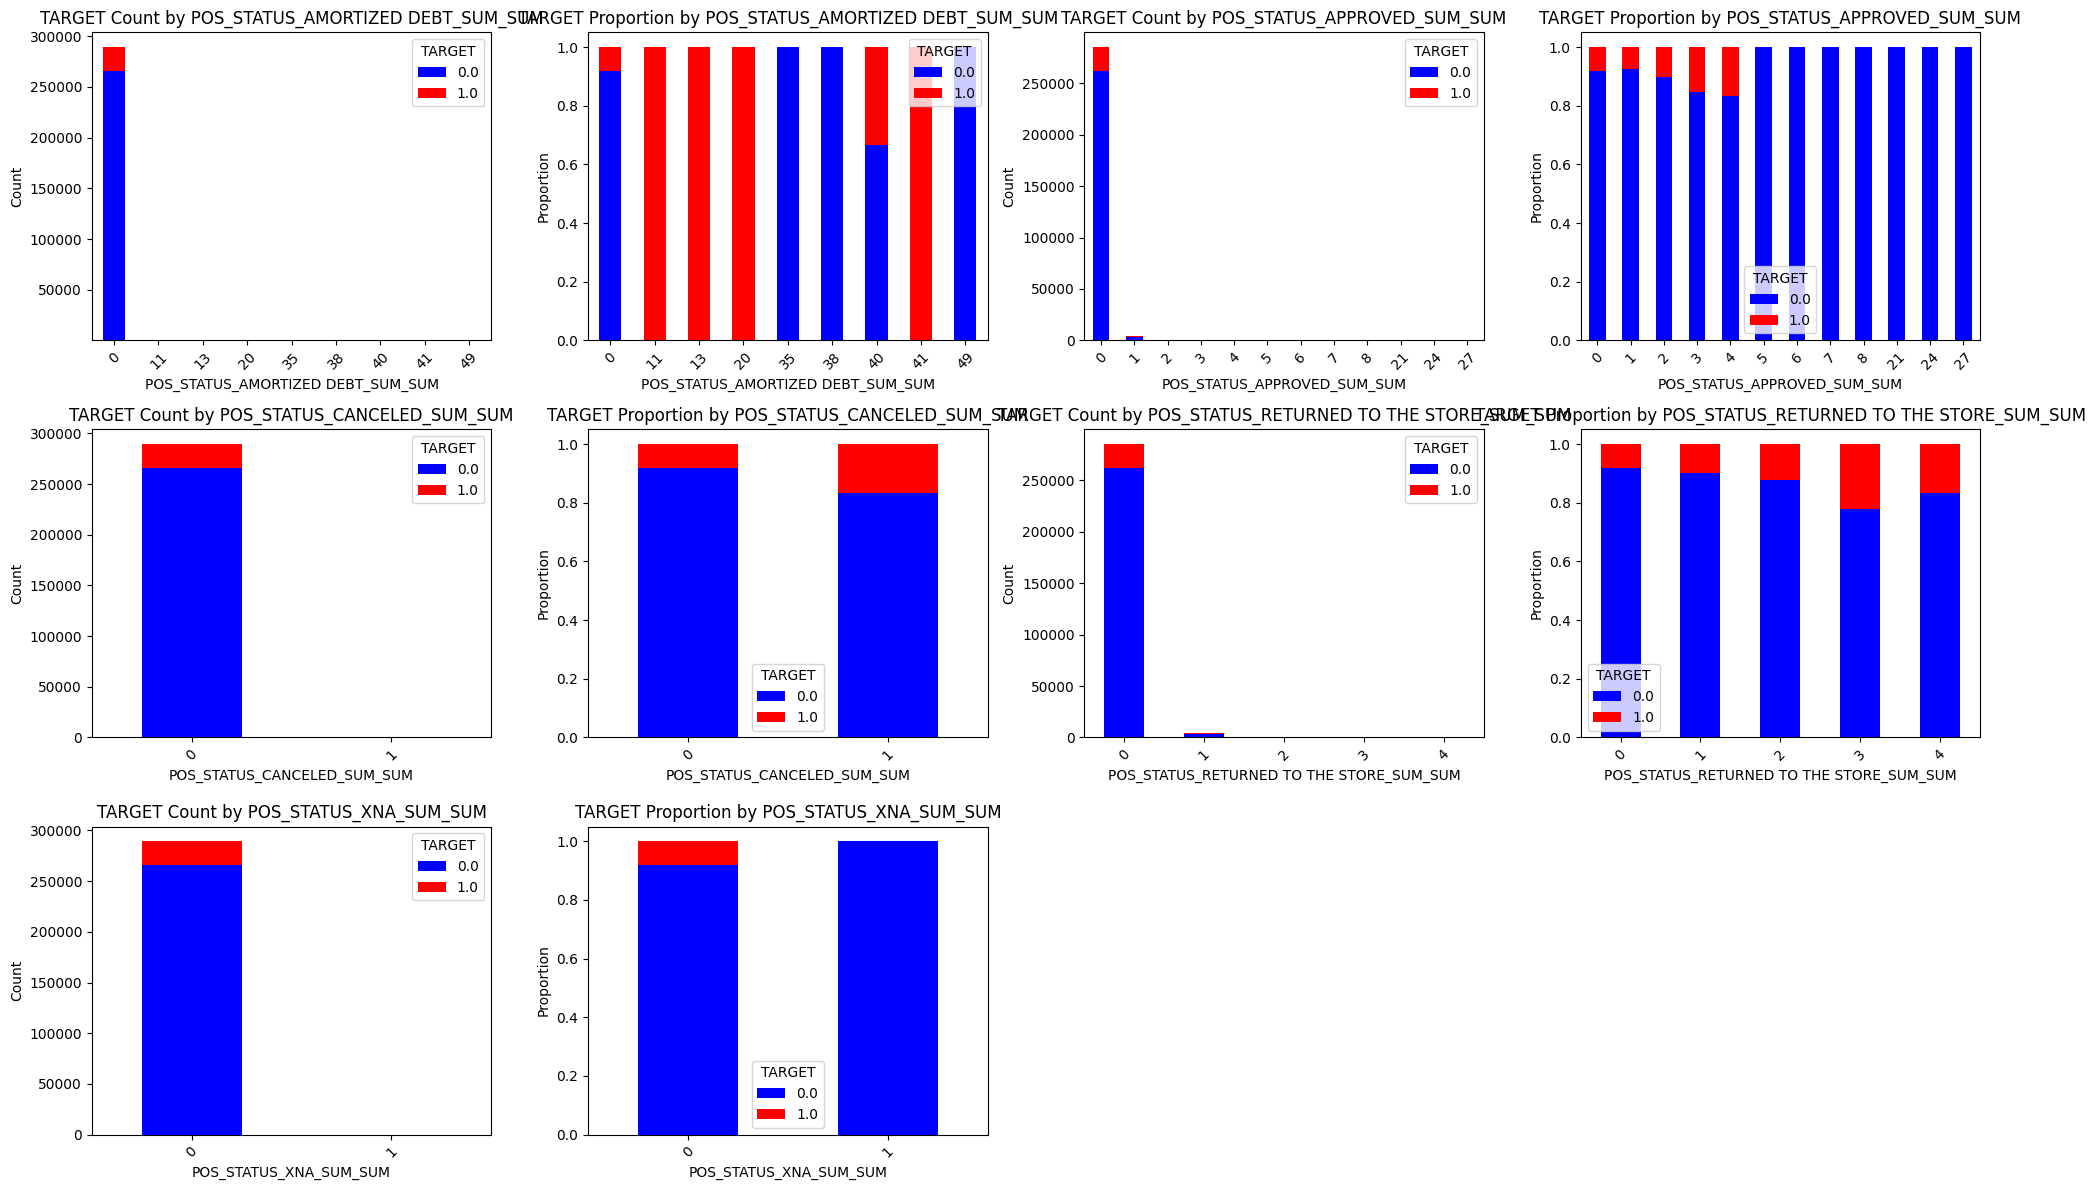

In [19]:
plot_multiple_categorical_dists(
    agg_pos_eda,
    features = [
        'POS_STATUS_AMORTIZED DEBT_SUM_SUM',
        'POS_STATUS_APPROVED_SUM_SUM',
        'POS_STATUS_CANCELED_SUM_SUM',
        'POS_STATUS_RETURNED TO THE STORE_SUM_SUM',
        'POS_STATUS_XNA_SUM_SUM'
    ],
    target = 'TARGET'
)

1. POS_STATUS_AMORTIZED_DEBT_SUM_SUM: The TARGET Count plot shows that most of the values are concentrated at 0, with few non-zero values. The TARGET Proportion plot reveals a consistent proportion of defaults (TARGET=1) across all values, suggesting that this feature has little discriminatory power for distinguishing between defaulted and non-defaulted clients.
2. POS_STATUS_CANCELED_SUM_SUM: Similar to POS_STATUS_AMORTIZED_DEBT_SUM_SUM, the distribution is heavily concentrated around 0, with a very small proportion of values deviating from it. The TARGET Proportion plot shows a consistent proportion of defaults across values, indicating that this feature does not offer significant predictive power for identifying defaults and might be redundant.
3. POS_STATUS_APPROVED_SUM_SUM: The distribution is highly concentrated around 0 with a few values spread out in the higher range. The TARGET Proportion plot shows a fairly consistent proportion of defaults (TARGET=1) across the feature's values, indicating that this feature has limited ability to distinguish between the two target classes.
4. POS_STATUS_RETURNED_TO_THE_STORE_SUM_SUM: This feature shows a similar pattern to POS_STATUS_APPROVED_SUM_SUM, with most values near 0 and few clients having non-zero values. The TARGET Proportion plot also shows a relatively constant proportion of defaults across values, which suggests that the feature does not provide strong discriminatory power.
5. POS_STATUS_XNA_SUM_SUM: The distribution is heavily skewed, with the vast majority of values concentrated at 0. The TARGET Proportion plot reveals that the proportion of defaults remains stable, indicating that this feature lacks variability and doesn't significantly help in distinguishing between defaulted and non-defaulted clients.

### Contract Status Features (Mean Aggregations)

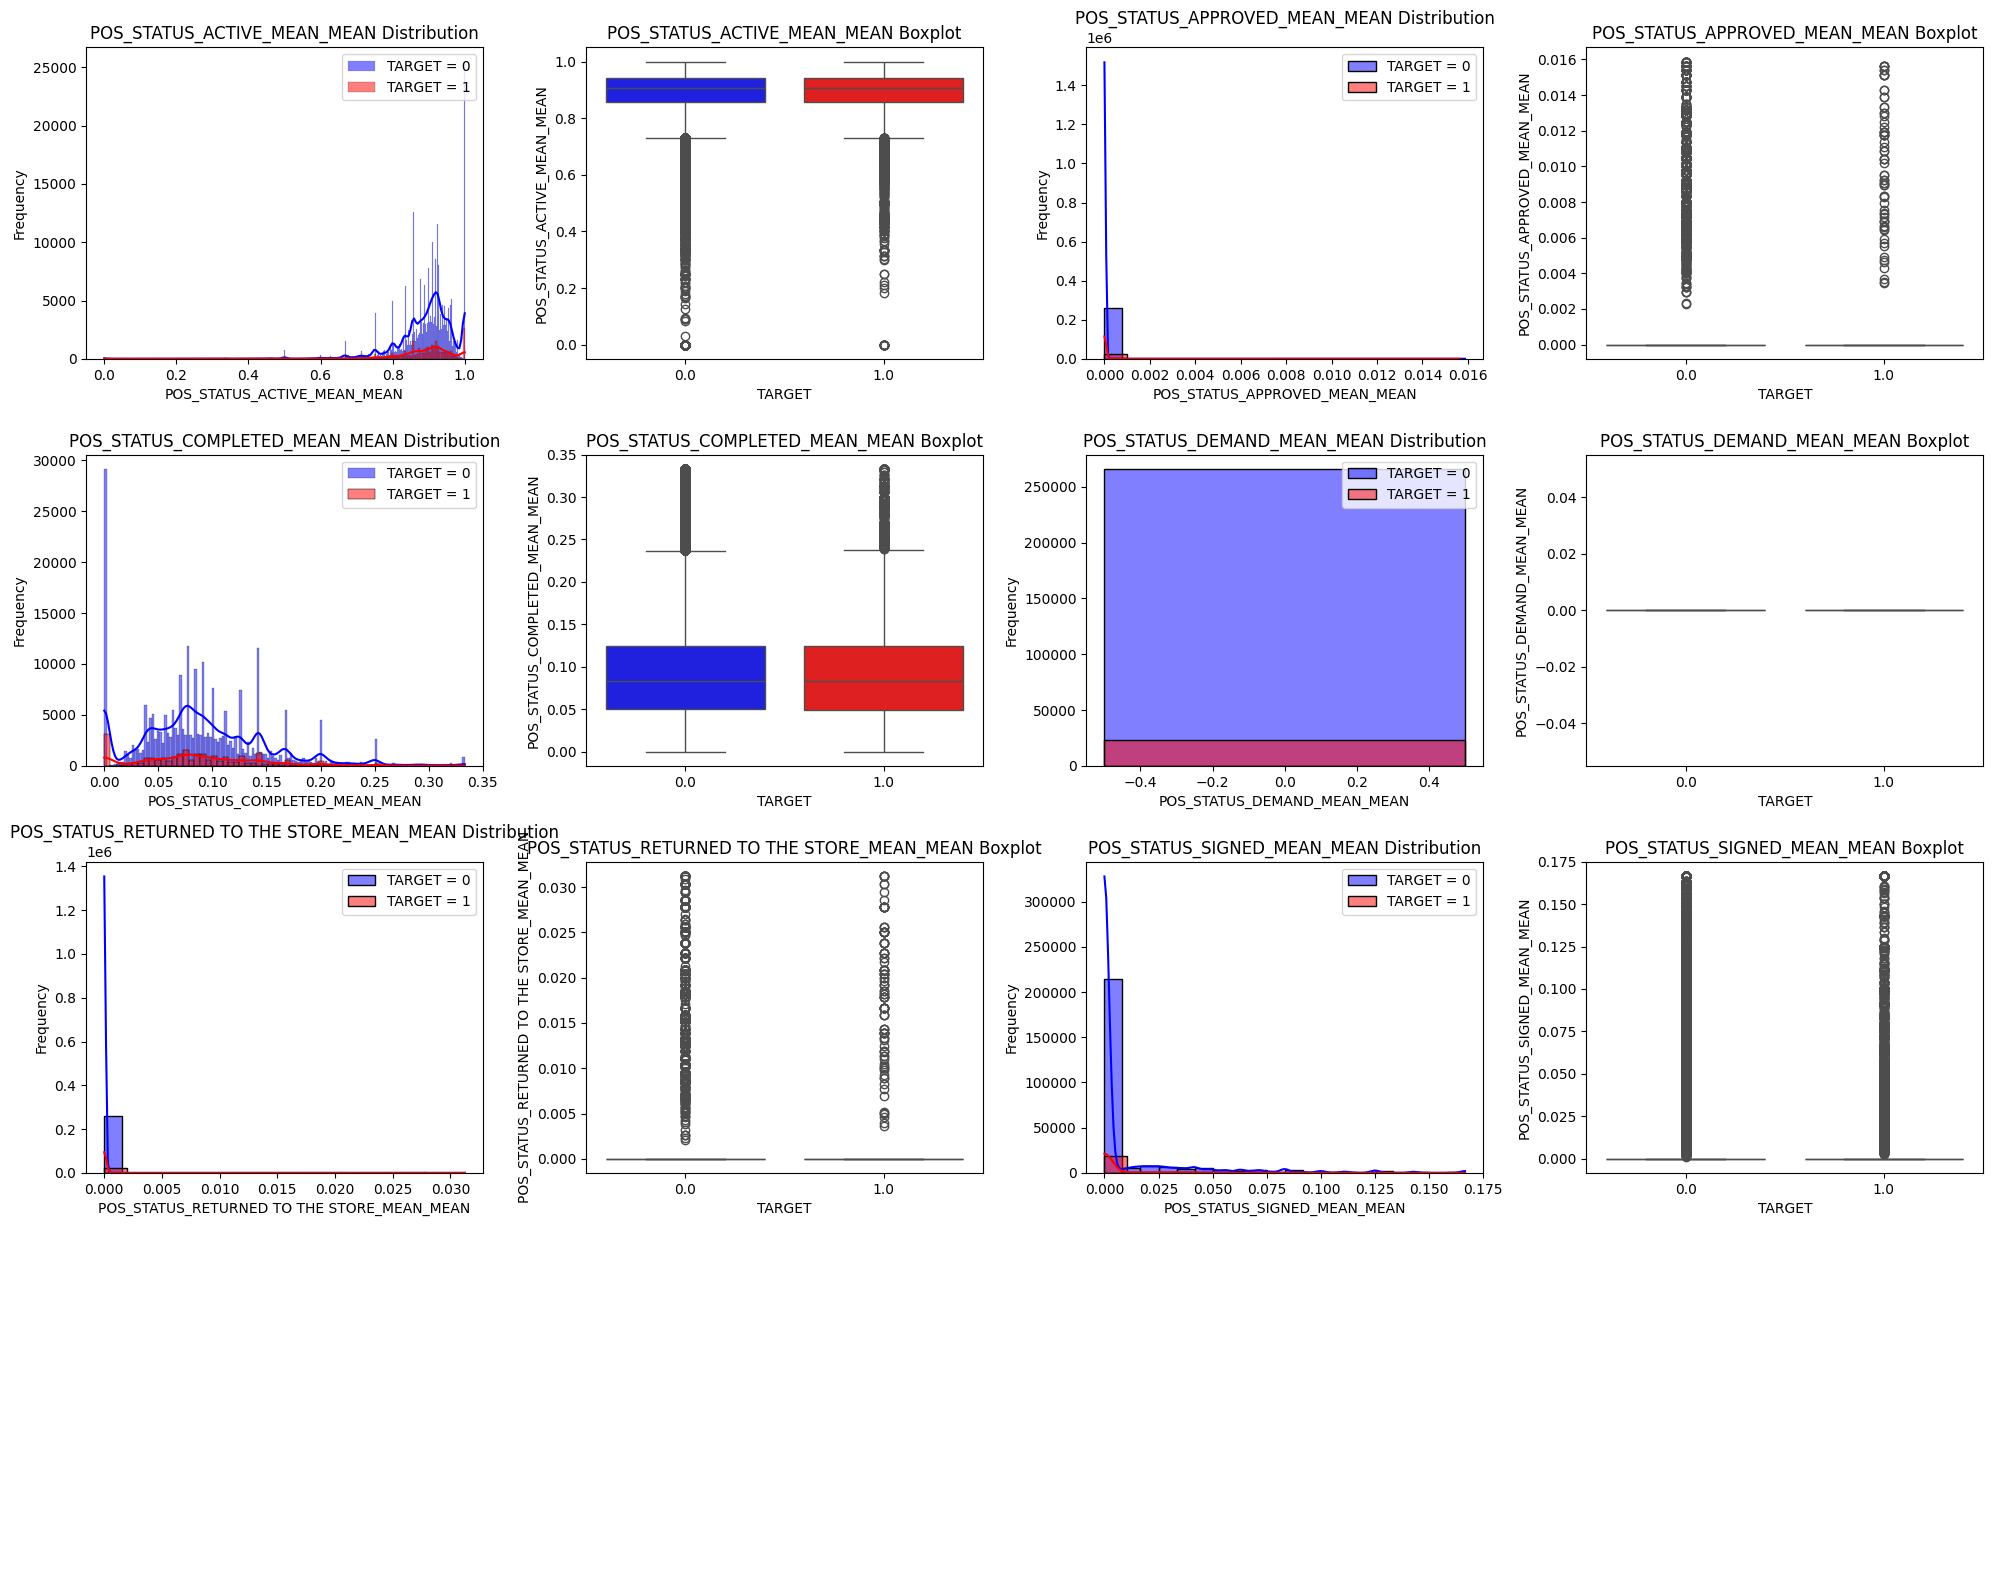

In [20]:
plot_multiple_numeric_dists(
    agg_pos_eda,
    features = [
        'POS_STATUS_ACTIVE_MEAN_MEAN',
        'POS_STATUS_APPROVED_MEAN_MEAN',
        'POS_STATUS_COMPLETED_MEAN_MEAN',
        'POS_STATUS_DEMAND_MEAN_MEAN',
        'POS_STATUS_RETURNED TO THE STORE_MEAN_MEAN',
        'POS_STATUS_SIGNED_MEAN_MEAN'
    ],
    target = 'TARGET',
    remove_outliers = True,
    outlier_features = [
        'POS_STATUS_ACTIVE_MEAN_MEAN',
        'POS_STATUS_APPROVED_MEAN_MEAN',
        'POS_STATUS_COMPLETED_MEAN_MEAN',
        'POS_STATUS_DEMAND_MEAN_MEAN',
        'POS_STATUS_RETURNED TO THE STORE_MEAN_MEAN',
        'POS_STATUS_SIGNED_MEAN_MEAN'
    ],
    percentile =0.99
)

1. POS_STATUS_ACTIVE_MEAN_MEAN: The distribution is right-skewed with most values concentrated near 0, and the boxplot reveals some outliers. The spread for TARGET=1 (defaults) is wider compared to TARGET=0, suggesting that clients with higher values for this feature may have a slightly higher likelihood of defaulting. The feature could be useful but may require handling of outliers and skewness.
2. POS_STATUS_COMPLETED_MEAN_MEAN: This feature also shows a right-skewed distribution, with most values around 0 and a long tail. The boxplot indicates that TARGET=1 has a wider spread than TARGET=0, suggesting that clients with higher POS_STATUS_COMPLETED_MEAN_MEAN values are more likely to default. However, outliers should be treated to avoid distortion in the model.
3. POS_STATUS_APPROVED_MEAN_MEAN: The distribution for this feature shows a concentration of values near 0, and the boxplot shows extreme outliers for TARGET=1. Since most values are near 0 and there is little variation, this feature seems less informative, and it might not add significant value in distinguishing between defaults and non-defaults.
4. POS_STATUS_DEMAND_MEAN_MEAN has no variation across the dataset—its values are essentially constant and centered at 0 for both TARGET = 0 and TARGET = 1. The distribution and boxplot show no spread or difference between the two classes. Because it carries no meaningful information, this feature is not useful for modeling and should be removed.
5. POS_STATUS_RETURNED_TO_THE_STORE_MEAN_MEAN: The distribution is concentrated around 0 with a small peak, and the boxplot shows extreme outliers. TARGET=1 shows a wider spread compared to TARGET=0, but since the feature is mostly concentrated around 0, its utility in predicting defaults is limited. Outlier treatment and transformation are necessary for effective use.
6. POS_STATUS_SIGNED_MEAN_MEAN: The distribution is heavily right-skewed with most values near 0, and the boxplot reveals extreme outliers. The spread for TARGET=1 is much wider, indicating that higher values might be associated with a higher likelihood of default. However, the feature needs to be carefully processed to handle outliers and skewness before being included in a model.

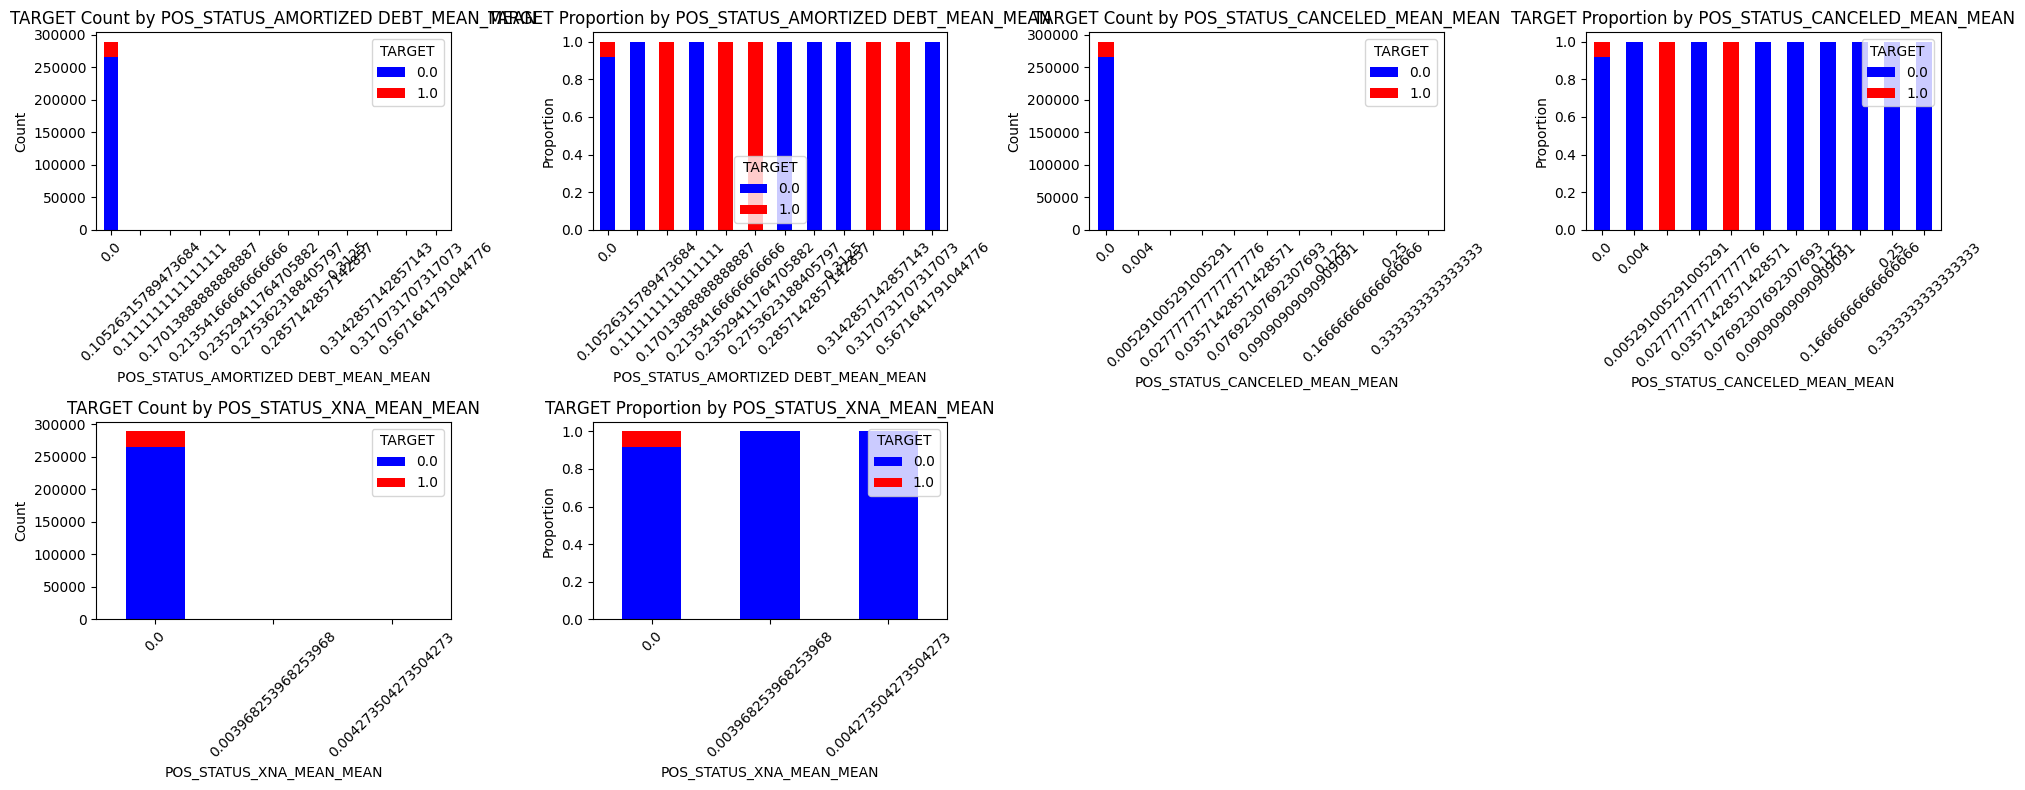

In [21]:
plot_multiple_categorical_dists(
    agg_pos_eda,
    features = [
        'POS_STATUS_AMORTIZED DEBT_MEAN_MEAN',
        'POS_STATUS_CANCELED_MEAN_MEAN',
        'POS_STATUS_XNA_MEAN_MEAN'
    ],
    target = 'TARGET'
)

1. POS_STATUS_AMORTIZED_DEBT_MEAN_MEAN: The distribution is highly concentrated around 0 with some non-zero values. The TARGET Proportion plot shows that the proportion of defaults (TARGET=1) is consistent across values. This suggests that this feature lacks variability and is unlikely to be useful for distinguishing between defaulted and non-defaulted clients, making it a candidate for removal.
2. POS_STATUS_CANCELED_MEAN_MEAN: Similar to POS_STATUS_AMORTIZED_DEBT_MEAN_MEAN, the distribution is highly concentrated around 0 with a few values spread out. The TARGET Proportion plot shows little difference between TARGET=0 and TARGET=1, indicating this feature has limited discriminatory power. It might not provide additional insights for the model and could be considered for removal.
3. POS_STATUS_XNA_MEAN_MEAN: The distribution is heavily concentrated at 0, with very few non-zero values. The TARGET Proportion plot indicates that the proportion of defaults is almost constant across values, suggesting that this feature has little predictive power. This feature may also be removed due to its lack of variability and ability to distinguish between defaulted and non-defaulted clients.

# Feature Importance and Selection

Feature selection involves choosing features with an importance score above 0.75. If two features have similar importance, the one with the higher score is kept. Features with zero importance are removed to simplify the dataset. After selecting these features, the LightGBM model is retrained. Finally, the model's accuracy and ROC-AUC score are checked to see how the selected features affect its performance.

#### Preparing the Data

In [22]:
agg_pos = agg_pos[agg_pos['TARGET'].notnull()]
X = agg_pos.drop(columns=['TARGET', 'SK_ID_CURR'], axis=1)
y = agg_pos['TARGET']

#### Splitting the Data

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

#### Training the Initial LightGBM Model

In [24]:
lgb_model = LGBMClassifier(is_unbalance=True, objective='binary', metric='auc')
lgb_model.fit(X_train, y_train)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 18897, number of negative: 212658
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010467 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5243
[LightGBM] [Info] Number of data points in the train set: 231555, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.081609 -> initscore=-2.420682
[LightGBM] [Info] Start training from score -2.420682


LGBMClassifier(is_unbalance=True, metric='auc', objective='binary')

In [25]:
y_pred = lgb_model.predict(X_test)
y_pred_proba = lgb_model.predict_proba(X_test)[:, 1]

#### Evaluating the Model

In [26]:
print("Classification Report (All Features):")
print(classification_report(y_test, y_pred))

Classification Report (All Features):
              precision    recall  f1-score   support

         0.0       0.94      0.58      0.71     53165
         1.0       0.10      0.56      0.18      4724

    accuracy                           0.58     57889
   macro avg       0.52      0.57      0.45     57889
weighted avg       0.87      0.58      0.67     57889



The model catches 56% of defaulters (recall = 0.56), which is good. However, the F1-score is low (0.18), meaning it predicts many false defaulters. So, while recall is strong, precision could need some improvement.

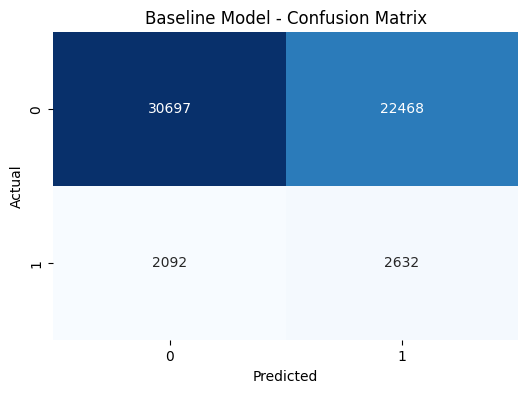

In [27]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title("Baseline Model - Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

The confusion matrix shows that the model correctly predicted 30,697 non-defaulters and 2,632 defaulters. However, it also misclassified 22,468 non-defaulters as defaulters and missed 2,092 actual defaulters. This matches the earlier metrics: good at finding defaulters, but still mislabels many who would repay.

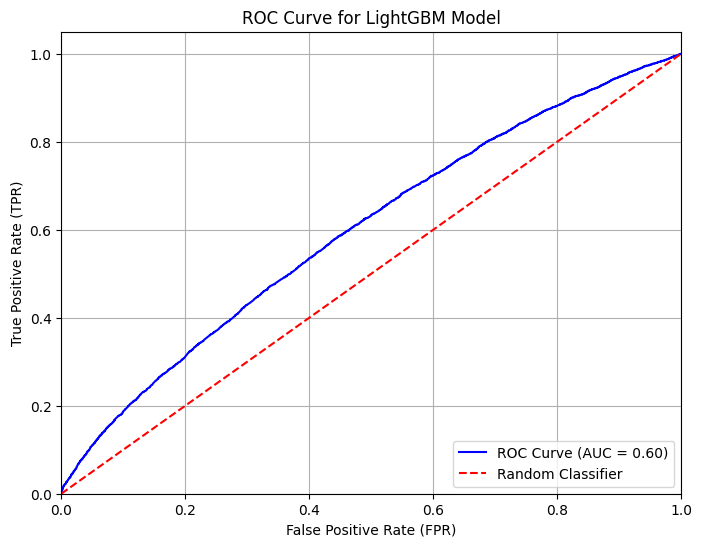

In [28]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--', label='Random Classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC Curve for LightGBM Model')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

The ROC curve shows that the model performs better than random guessing, with an AUC of 0.60. This means it has a fair ability to distinguish between defaulters and non-defaulters, but there’s still room for improvement to reach stronger predictive power.

#### Calculate Feature Importance

In [29]:
importances = lgb_model.feature_importances_
feature_names = X_train.columns
feature_importance_df = pd.DataFrame({'feature': feature_names, 'importance': importances})

#### Compute the Correlation Matrix

In [30]:
corr_matrix = X_train.corr().abs()

#### Identify and Remove Redundant Features

In [31]:
high_corr_pairs = []
threshold = 0.75
for i in range(len(corr_matrix.columns)):
    for j in range(i + 1, len(corr_matrix.columns)):
        if corr_matrix.iloc[i, j] > threshold:
            high_corr_pairs.append((corr_matrix.columns[i], corr_matrix.columns[j]))

features_to_remove = set()
for feat1, feat2 in high_corr_pairs:
    imp1 = feature_importance_df.loc[feature_importance_df['feature'] == feat1, 'importance'].values[0]
    imp2 = feature_importance_df.loc[feature_importance_df['feature'] == feat2, 'importance'].values[0]
    if imp1 > imp2:
        features_to_remove.add(feat2)
    else:
        features_to_remove.add(feat1)

#### Removing the features with the lower importance score

In [32]:
low_imp_threshold = 0
low_importance_features = feature_importance_df[feature_importance_df['importance'] < low_imp_threshold]['feature']
features_to_remove.update(low_importance_features)

#### Retraining and evaluating the LightGBM model using only selected features

In [33]:
selected_features = [feat for feat in feature_names if feat not in features_to_remove]
X_train_selected = X_train[selected_features]
X_test_selected = X_test[selected_features]

lgb_model.fit(X_train_selected, y_train)
y_pred = lgb_model.predict(X_test_selected)
print(classification_report(y_test, y_pred))

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 18897, number of negative: 212658
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006620 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2775
[LightGBM] [Info] Number of data points in the train set: 231555, number of used features: 19
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.081609 -> initscore=-2.420682
[LightGBM] [Info] Start training from score -2.420682
              precision    recall  f1-score   support

         0.0       0.94      0.57      0.71     53165
         1.0       0.10      0.56      0.18      4724

    accuracy                           0.57     57889
   macro avg       0.52      0.57      0.44     57889
weighted avg       0.87      0.57      0.67     57889



After feature selection, the recall and F1-score for class 1 remained unchanged at 0.56 and 0.18, indicating the model's ability to identify defaulters stayed consistent even with fewer features.

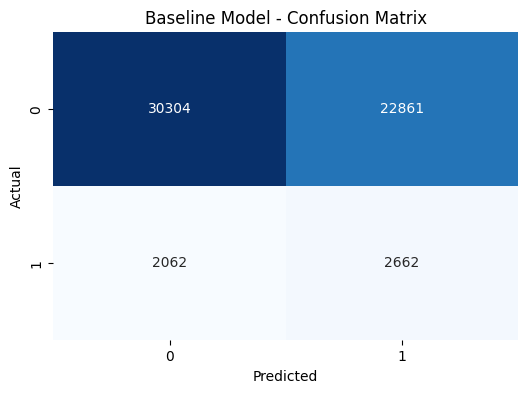

In [34]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title("Baseline Model - Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

The number of true positives and false negatives slightly changed after feature selection (2,632 vs. 2,662 and 2,092 vs. 2,064), showing a nearly identical prediction pattern with reduced feature complexity.

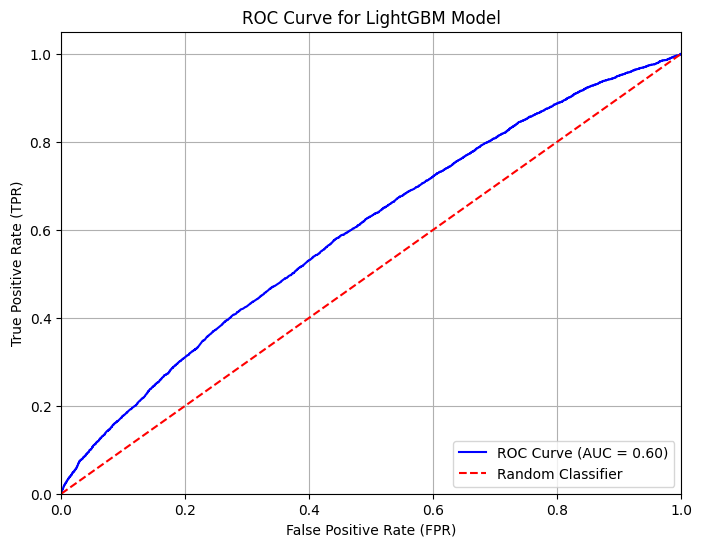

In [35]:
y_pred_proba = lgb_model.predict_proba(X_test_selected)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--', label='Random Classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC Curve for LightGBM Model')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

The AUC remains at 0.60, showing that the model's ability to distinguish between defaulters and non-defaulters has not changed after reducing the number of features. This means feature selection helped simplify the model without hurting its performance.

# Conclusion

To prepare the data for modeling, we aggregated the POS_CASH features, which helped reduce the size and complexity of the input for the machine learning model.

We used the LightGBM classifier with is_unbalance=True to handle the imbalanced target variable. This choice aligns with the competition’s final model setup, keeping our approach consistent.

## Feature Engineering and Selection

* After creating new features from both datasets, we checked their value by using a machine learning model.
* We used feature importance scores to select the most useful features and dropped the ones that didn’t help (importance = 0).
* We also compared similar features and kept only the better ones.

After applying feature selection, we removed the least important features listed in features_to_remove:

In [36]:
features_to_remove

{'POS_CNT_INSTALMENT_MEAN_MAX',
 'POS_CNT_INSTALMENT_MEAN_MEAN',
 'POS_MONTHS_BALANCE_COUNT_MAX',
 'POS_MONTHS_BALANCE_COUNT_SUM',
 'POS_SK_DPD_DEF_MAX_MAX',
 'POS_SK_DPD_DEF_MAX_MEAN',
 'POS_SK_DPD_DEF_SUM_SUM',
 'POS_SK_DPD_MAX_MAX',
 'POS_SK_DPD_MEAN_MEAN',
 'POS_SK_DPD_SUM_SUM',
 'POS_SK_ID_PREV_COUNT',
 'POS_STATUS_ACTIVE_MEAN_MEAN',
 'POS_STATUS_AMORTIZED DEBT_SUM_SUM',
 'POS_STATUS_CANCELED_SUM_SUM'}

### Final Dataset for Modeling

After feature selection, the dataset became simpler and easier to work with. However, this may have led to the removal of some useful information, slightly impacting performance. The final LightGBM model achieved an AUC of 0.60, indicating fair predictive ability. It successfully identified 56% of clients likely to default (recall), but the F1-score was low (0.18), meaning many of the predictions were incorrect. Overall, the model balances simplicity and performance but leaves room for further improvement.

After processing, we created a clean and powerful dataset ready for modeling, with fewer but more meaningful features.

### Model Performance Note

The final model’s performance, using these engineered features, is evaluated in detail in the LightGBM Pipeline Notebook.

In [37]:
agg_pos_selected = agg_pos[['SK_ID_CURR'] + selected_features]
agg_pos_selected.to_csv('data/agg_pos_selected.csv', index=False)

In [38]:
agg_pos_selected

,SK_ID_CURR,POS_MONTHS_BALANCE_COUNT_MEAN,POS_MONTHS_BALANCE_MAX_MAX,POS_CNT_INSTALMENT_MEAN_MIN,POS_CNT_INSTALMENT_FUTURE_MIN_MIN,POS_CNT_INSTALMENT_FUTURE_MIN_MEAN,POS_CNT_INSTALMENT_FUTURE_MEAN_MEAN,POS_SK_DPD_MAX_MEAN,POS_SK_DPD_DEF_MEAN_MEAN,POS_STATUS_ACTIVE_SUM_SUM,...,POS_STATUS_SIGNED_SUM_SUM,POS_STATUS_XNA_SUM_SUM,POS_STATUS_AMORTIZED DEBT_MEAN_MEAN,POS_STATUS_APPROVED_MEAN_MEAN,POS_STATUS_CANCELED_MEAN_MEAN,POS_STATUS_COMPLETED_MEAN_MEAN,POS_STATUS_DEMAND_MEAN_MEAN,POS_STATUS_RETURNED TO THE STORE_MEAN_MEAN,POS_STATUS_SIGNED_MEAN_MEAN,POS_STATUS_XNA_MEAN_MEAN
1,100002,19.000000,-1,24.000,6.0,6.000000,15.000000,0.000000,0.000000,19,...,0,0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0
2,100003,9.333333,-18,6.000,0.0,0.333333,5.666667,0.000000,0.000000,26,...,0,0,0.0,0.0,0.0,0.083333,0.0,0.000000,0.000000,0.0
3,100004,4.000000,-24,3.750,0.0,0.000000,2.250000,0.000000,0.000000,3,...,0,0,0.0,0.0,0.0,0.250000,0.0,0.000000,0.000000,0.0
5,100006,7.000000,-1,10.000,0.0,1.000000,10.214286,0.000000,0.000000,18,...,0,0,0.0,0.0,0.0,0.152778,0.0,0.041667,0.000000,0.0
6,100007,13.200000,-1,10.000,0.0,2.800000,8.966667,0.000000,0.000000,62,...,1,0,0.0,0.0,0.0,0.041880,0.0,0.000000,0.015385,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
337247,456251,9.000000,-1,7.875,0.0,0.000000,4.375000,0.000000,0.000000,7,...,1,0,0.0,0.0,0.0,0.111111,0.0,0.000000,0.111111,0.0
337248,456252,7.000000,-76,6.000,0.0,0.000000,3.000000,0.000000,0.000000,6,...,0,0,0.0,0.0,0.0,0.142857,0.0,0.000000,0.000000,0.0
337249,456253,5.666667,-57,4.000,0.0,0.000000,1.805556,1.666667,0.277778,15,...,0,0,0.0,0.0,0.0,0.138889,0.0,0.000000,0.000000,0.0
337250,456254,10.000000,-1,14.000,4.0,6.000000,10.500000,0.000000,0.000000,20,...,0,0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0
